#  Project 1 - Bee Subspecie Classification (logistic regression vs neural network approach) 

### Import relevant libraries

In [1]:
import sys
import numpy as np
np.set_printoptions(threshold=sys.maxsize)
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import plotly.express as px
from sklearn.model_selection import train_test_split
#to load matlab mat files
from scipy.io import loadmat

size = 50

## PART 2: Load data

In [2]:
ds = pd.read_csv('bee_dataset/ml_data.csv')
features=ds['features']
y1=ds['class']
y2 = {'Italian honey bee':1,'Carniolan honey bee':2,
      'Russian honey bee':3,'1 Mixed local stock 2':4,'Western honey bee':5}
y = (pd.Series(y1)).map(y2)
y = np.array(y)
y = np.reshape(y, (-1, 1))
#print(type(y))
#print(y)
n_examples = features.shape[0]
feature_size = size*size
X = np.empty((n_examples,feature_size), float)
for idx,f in enumerate(features):
        arr_f = np.fromstring(f, dtype=float, sep=' ')
        arr_f = np.reshape(arr_f, (1,arr_f.shape[0]))
        X[idx,:] = np.copy(arr_f)
#X = np.copy(arr)
#print(y.shape)
#print(X.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(406, 2500) (406, 1)
(102, 2500) (102, 1)


508


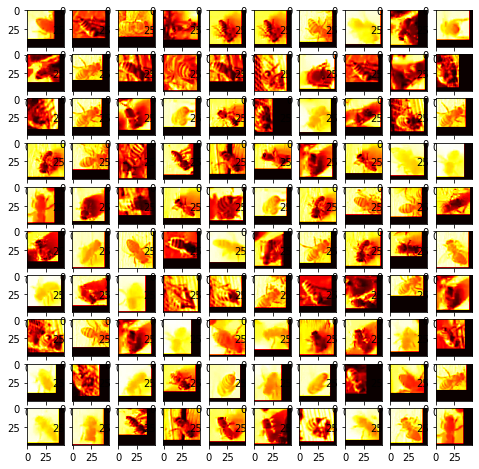

In [3]:
print(n_examples)
fig, axis = plt.subplots(10,10,figsize=(8,8))
for i in range(10):
    for j in range(10):
                                                        #reshape back to 20x20 pixel image
        axis[i,j].imshow(X[np.random.randint(0,n_examples),:].reshape(size,size,order="F"), cmap="hot")

In [4]:
# Add sigmoid FUNCTION from the previous lab
def sigmoid(z):
    """
    return the sigmoid of z
    """
    gz= 1/(1+np.exp(-z))

    return gz

In [5]:
# Add costFunctionReg FUNCTION from the previous lab (the function that computes the regularized cost and the gradients)
def costFunctionReg(X, y, theta, Lambda):
    """
    Take in numpy array of  data X, labels y and theta, to return the regularized cost function and gradients
    of the logistic regression classifier
    """
    
    #number of training examples 
    m = len(y)
        
    #vector of the model predictions for all training examples      
    h = sigmoid(np.dot(X,theta))
    
    error = (-y * np.log(h)) - ((1-y)*np.log(1-h))
    
    #cost function without regularization term
    cost = sum(error)/m
    
    #add regularization term to the cost function L2 norm
    regCost= cost + Lambda/(2*m) * sum(theta[1:]**2)
    
    #gradient of theta_0
    grad_0= (1/m) * np.dot(X.transpose(),(h - y))[0]
    
    #vector of gradients of theta_j from j=1:n (adding the regularization term of the gradient)
    grad = (1/m) * np.dot(X.transpose(),(h - y))[1:] + (Lambda/m)* theta[1:]
       
    # all gradients in a column vector shape
    grad_all=np.append(grad_0,grad)
    grad_all = grad_all.reshape((len(grad_all), 1))
    
    return regCost[0], grad_all

In [6]:
# Add gradientDescent FUNCTION from the previous lab (the function that returns the optimal theta vector and J_history)
def gradientDescent(X,y,theta,alpha,num_iters,Lambda):
    """
    Take in numpy array X, y and theta and update theta by taking num_iters gradient steps
    with learning rate of alpha
    
    return theta and the list of the cost of theta during each iteration
    """
    
    J_history =[]
    
    for i in range(num_iters):
        
        #call CostFunctionReg 
        cost, grad = costFunctionReg(X,y,theta,Lambda)
        
        #update theta
        descent = alpha * grad
        theta = theta - descent #theta - (alpha*grad)
        
        J_history.append(cost)
    
    return theta , J_history

In [7]:
def oneVsAll(X, y, initial_theta, alpha, num_iters, Lambda, K):
    """
    Inputs:
    numpy array of data X and labels y
    initial_theta - inicialized vector of model parameters theta 
    alpha - learning rate
    num_iters - number of iterations
    Lambda - regularization parameter 
    K -number of classes
    
    ONEVSALL trains K Logistic Regression classifiers using gradient descent. 
    
    Returns:   
    all_theta - Kxn matrix where i-th row corresponds to the i-th classifier, n parameters
    all_J - the evolution of cost function during each iteration (J_history) for all K classifiers
    
    """
    all_theta = []
    all_J=[]
    
    #number of training examples
    m=X.shape[0]
    
    #number of features
    n=X.shape[1]
    
    # add an extra column of 1´s corresponding to xo=1 (aka intercept term)
    X = np.append(np.ones((m,1)),X,axis=1)
    
    for i in range(1,K+1):
        y = np.where(y==i,1,0)
        theta , J_history = gradientDescent(X,y,initial_theta,alpha,num_iters,Lambda)
        
        # sdd the vector of optimized parameters theta of classifier i
        all_theta.extend(theta)
                
        # add the cost function history of classifier i
        all_J.extend(J_history)
        
    return np.array(all_theta).reshape(K,n+1), all_J

In [8]:
#Inicialize vector theta =0
initial_theta = np.zeros((X.shape[1] + 1, 1))

#Optimization hyper-parameters 
alpha=1 #learning rate
num_iters=300
Lambda=0.1

all_theta, all_J = oneVsAll(X, y, initial_theta, alpha, num_iters, Lambda, 5)

C:\Users\biaco\AppData\Local\Temp/ipykernel_11040/1828240669.py:14: RuntimeWarning: divide by zero encountered in log
  error = (-y * np.log(h)) - ((1-y)*np.log(1-h))
C:\Users\biaco\AppData\Local\Temp/ipykernel_11040/1828240669.py:14: RuntimeWarning: invalid value encountered in multiply
  error = (-y * np.log(h)) - ((1-y)*np.log(1-h))


Text(0.5, 1.0, 'Cost function using Gradient Descent')

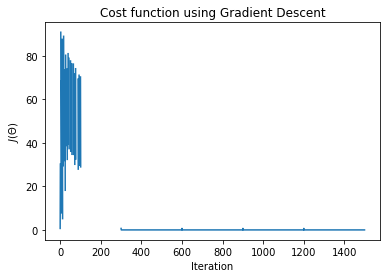

In [9]:
plt.plot(all_J)  #All classifiers
plt.xlabel("Iteration")
plt.ylabel("$J(\Theta)$")
plt.title("Cost function using Gradient Descent")

In [10]:
def predictOneVsAll(all_theta, X):
    """
    Using all_theta, compute the probability of image X(i) for each class and predict the label
    
    return a vector of prediction
    """
    #number of training examples
    m = X.shape[0]
    
    # add an extra column of 1´s corresponding to xo=1 (aka intercept term)
    X = np.append(np.ones((m,1)),X,axis=1)
    
    predictions = np.dot (X, all_theta.T) # predictions.shape =(5000,10)  X(5000x401) * all_theta(401x10) = 5000x10
    #np.argmax returns indices of the max element of the array in a particular axis.
    #+1 in order to label 0 as 10. 
    return np.argmax(predictions,axis=1)+1

In [11]:
pred = predictOneVsAll(all_theta, X)

#Check that pred.shape  = (5000,) => rank 1 array. You need to reshape it !!!
pred = pred.reshape((pred.shape[0], 1))
m = X.shape[0]
print("Training Set Accuracy:",sum(pred==y)[0]/m*100,"%")

Training Set Accuracy: 37.40157480314961 %
